# Structured Representations

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.spa import Vocabulary

In [3]:
DIM = 20
N_NEURONS = 300

In [12]:
rng = np.random.RandomState(0)
vocab = Vocabulary(dimensions=DIM, rng=rng)

The `Vocabulary` allows you to store semantic pointers similar to a dictionary. The pointer names must begin with a capital
letter and be valid python variable names.

In [ ]:
print(vocab.keys, vocab.vectors)
vocab["A"]
print(vocab.keys, vocab.vectors)


[] []
['A'] [[ 0.3855076   0.08744845  0.21388874  0.48971413  0.40812723 -0.21356965
   0.2076278  -0.03307688 -0.02255696  0.08973024  0.0314786   0.31781001
   0.16631356  0.02659028  0.09699976  0.0729196   0.32650893 -0.04483431
   0.06841632 -0.18665002]]


In [41]:
net = nengo.Network(label="Structured Representations")
with net:
    in_a = nengo.Node(output=vocab["A"].v, label="Input A")
    in_b = nengo.Node(output=vocab["B"].v, label="Input B")

    ens_a = nengo.Ensemble(N_NEURONS, dimensions=DIM, label="A")
    ens_b = nengo.Ensemble(N_NEURONS, dimensions=DIM, label="B")
    # will let C = conv(A, B)
    ens_c = nengo.Ensemble(N_NEURONS, dimensions=DIM, label="C")

    ens_sum = nengo.Ensemble(N_NEURONS, dimensions=DIM, label="Sum")

    net_bind = nengo.networks.CircularConvolution(70, dimensions=DIM, label="Bind")

    nengo.Connection(in_a, ens_a)
    nengo.Connection(in_b, ens_b)
    # sum inputs
    nengo.Connection(ens_a, ens_sum)
    nengo.Connection(ens_b, ens_sum)

    # bind inputs
    nengo.Connection(ens_a, net_bind.A)
    nengo.Connection(ens_b, net_bind.B)
    nengo.Connection(net_bind.output, ens_c)

    in_a_probe = nengo.Probe(in_a)
    in_b_probe = nengo.Probe(in_b)

    a_probe = nengo.Probe(ens_a, synapse=0.03)
    b_probe = nengo.Probe(ens_b, synapse=0.03)
    c_probe = nengo.Probe(ens_c, synapse=0.03)
    sum_probe = nengo.Probe(ens_sum, synapse=0.03)

In [46]:
sim = nengo.Simulator(net)
with sim:
    sim.run(5.0)

/home/tariq/miniconda3/envs/nengo-tutorials/lib/python3.13/site-packages/nengo/builder/optimizer.py:654: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [47]:
n_dim_plot = 5

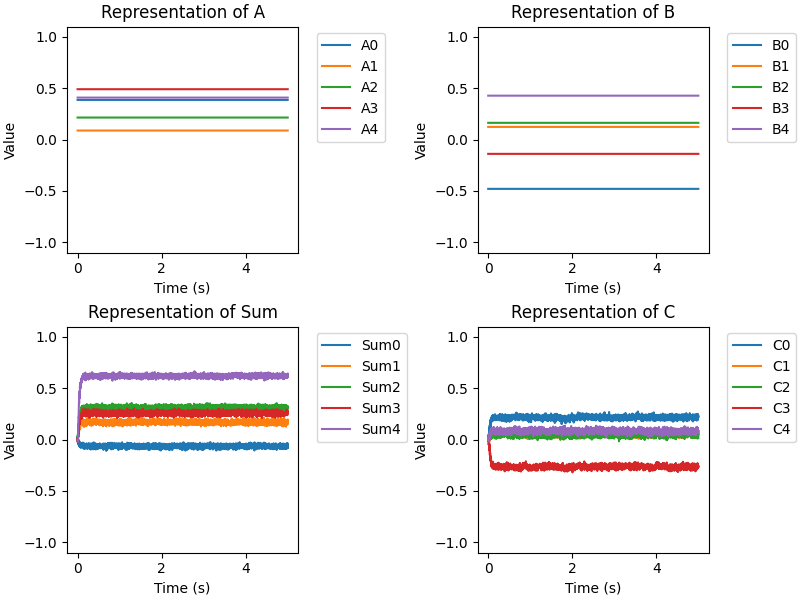

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
labels = ["A", "B", "Sum", "C"]
probes = [in_a_probe, in_b_probe, sum_probe, c_probe]
for a, p, l in zip(ax.flatten(), probes, labels):
    for i in range(n_dim_plot):
        a.plot(sim.trange(), sim.data[p][:, i], label=f"{l}{i}")

    a.set_title(f"Representation of {l}")
    a.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    a.set_ylim(-1.1, 1.1)
    a.set_xlabel("Time (s)")
    a.set_ylabel("Value")
plt.show()

/tmp/ipykernel_283032/4205475867.py:8: RuntimeWarning: invalid value encountered in divide
  sims = np.dot(sim.data[p], c_actual) / (np.linalg.norm(sim.data[p], axis=1) * np.linalg.norm(c_actual))


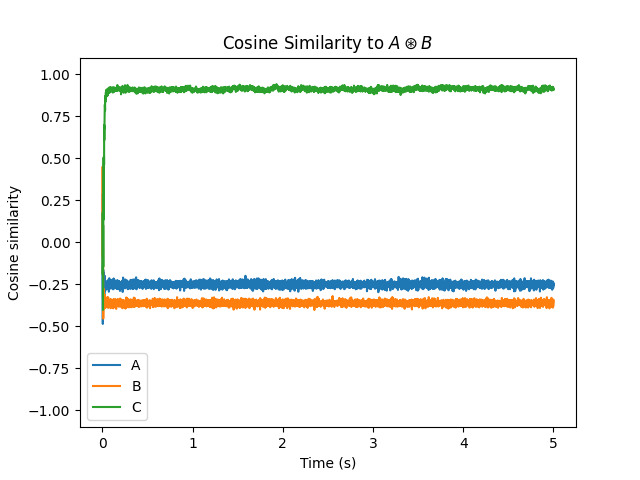

In [50]:
c_actual = np.real(np.fft.ifft(np.fft.fft(vocab["A"].v) * np.fft.fft(vocab["B"].v)))

labels = ["A", "B", "C"]
probes = [a_probe, b_probe, c_probe]
plt.figure()
plt.title("Cosine Similarity to $A \\circledast B$")
for p, l in zip(probes, labels):
    sims = np.dot(sim.data[p], c_actual) / (np.linalg.norm(sim.data[p], axis=1) * np.linalg.norm(c_actual))
    plt.plot(sim.trange(), sims, label=l)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Time (s)")
    plt.ylabel("Cosine similarity")
    plt.legend()
plt.show()

## Using SPA

In [51]:
import nengo.spa as spa

In [53]:
N_DIM = 32

In [54]:
rng = np.random.RandomState(0)
vocab = spa.Vocabulary(dimensions=N_DIM, rng=rng)
vocab.add("C", vocab.parse("A * B"))  # C = A ⊛ B
# Check that this is the same as manual circular convolution
assert np.allclose(vocab["C"].v, np.real(np.fft.ifft(np.fft.fft(vocab["A"].v) * np.fft.fft(vocab["B"].v))))

In [66]:
model = spa.SPA(label="SPA Structured Representations", vocabs=[vocab])
with model:
    model.A = spa.State(N_DIM)
    model.B = spa.State(N_DIM)
    # Note feedback is for memory but is not strictly necessary here
    model.C = spa.State(N_DIM, feedback=1)
    model.Sum = spa.State(N_DIM)
    actions = spa.Actions("C = A * B", "Sum = A + B")
    model.Cortical = spa.Cortical(actions)

    model.input = spa.Input(A="A", B="B")
    a_probe = nengo.Probe(model.A.output, synapse=0.03)
    b_probe = nengo.Probe(model.B.output, synapse=0.03)
    c_probe = nengo.Probe(model.C.output, synapse=0.03)
    sum_probe = nengo.Probe(model.Sum.output, synapse=0.03)

In [67]:
sim = nengo.Simulator(model)
with sim:
    sim.run(5.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tariq/miniconda3/envs/nengo-tutorials/lib/python3.13/site-packages/nengo/builder/optimizer.py:654: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/tmp/ipykernel_283032/785266817.py:10: RuntimeWarning: invalid value encountered in divide
  sims = np.dot(sim.data[p], vocab["C"].v) / (np.linalg.norm(sim.data[p], axis=1) * np.linalg.norm(vocab["C"].v))


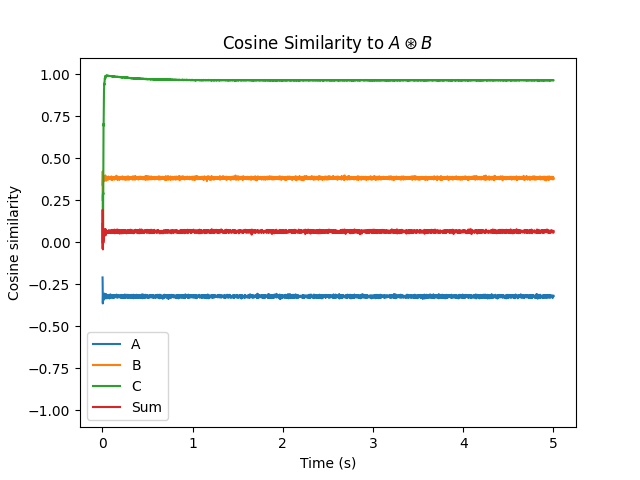

In [68]:
labels = ["A", "B", "C", "Sum"]
probes = [a_probe, b_probe, c_probe, sum_probe]
plt.figure()
plt.title("Cosine Similarity to $A \\circledast B$")
plt.ylim(-1.1, 1.1)
plt.xlabel("Time (s)")
plt.ylabel("Cosine similarity")

for p, l in zip(probes, labels):
    sims = np.dot(sim.data[p], vocab["C"].v) / (np.linalg.norm(sim.data[p], axis=1) * np.linalg.norm(vocab["C"].v))
    plt.plot(sim.trange(), sims, label=l)

plt.legend()
plt.show()


/tmp/ipykernel_283032/1554733847.py:11: RuntimeWarning: invalid value encountered in divide
  sims = np.dot(sim.data[p], ab_sum) / (np.linalg.norm(sim.data[p], axis=1) * np.linalg.norm(ab_sum))


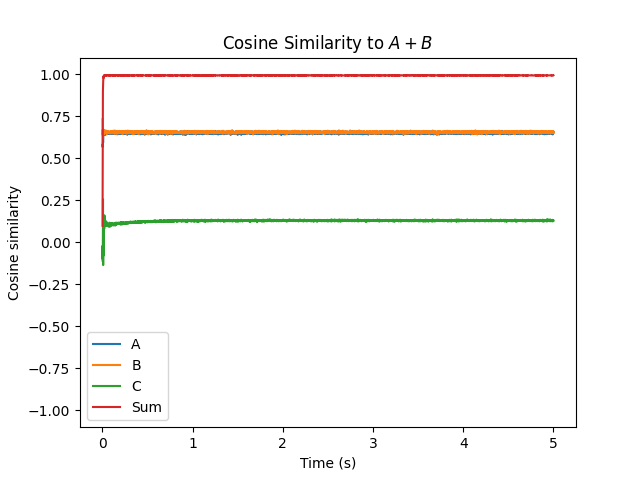

In [69]:
labels = ["A", "B", "C", "Sum"]
probes = [a_probe, b_probe, c_probe, sum_probe]
plt.figure()
plt.title("Cosine Similarity to $A + B$")
plt.ylim(-1.1, 1.1)
plt.xlabel("Time (s)")
plt.ylabel("Cosine similarity")

for p, l in zip(probes, labels):
    ab_sum = vocab["A"].v + vocab["B"].v
    sims = np.dot(sim.data[p], ab_sum) / (np.linalg.norm(sim.data[p], axis=1) * np.linalg.norm(ab_sum))
    plt.plot(sim.trange(), sims, label=l)

plt.legend()
plt.show()